In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# =============================================================================
# Imports #%%
# =============================================================================
#part| #%%
from datetime import datetime

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import FastICA
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
from tpot import TPOTRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf 
from tensorflow.keras import callbacks
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy
import joblib as joblib
import matplotlib.pyplot as plt

def max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def mse(ground_truth, predictions):
    diff = (ground_truth - predictions)**2
    return diff.mean()

def mae(ground_truth, predictions):
    diff = abs(ground_truth - predictions)
    return diff.mean()

df = pd.read_csv("../data/train/all_data_merged/fr/Enriched_Covid_history_data.csv")
df = df.dropna()
df["all_day_bing_tiles_visited_relative_change"]=df["all_day_bing_tiles_visited_relative_change"].astype(float)
df["all_day_ratio_single_tile_users"]=df["all_day_ratio_single_tile_users"].astype(float)
print(df)
columnstonormalize = ['pm25', 'no2','o3','pm10','co','pm257davg','no27davg','o37davg','co7davg', 'pm107davg','1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco']
# for c in columnstonormalize:
#     df[c]=max_normalize(df[c])

featuresandtarget = ['idx', 'pm25', 'no2',
'o3','pm10','co',\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg',\
        'hospiprevday','covidpostestprevday',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                             "minority",\
                                  "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",\
                                      '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco',\
                                          'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg',\
                                           'newhospi'\

                            ]
                                            
features = ['idx', 'pm25', 'no2',
'o3','pm10','co',\
    'pm257davg','no27davg',\
    'o37davg','co7davg', 'pm107davg',\
        'hospiprevday','covidpostestprevday',\
            'all_day_bing_tiles_visited_relative_change','all_day_ratio_single_tile_users','vac1nb', 'vac2nb',\
                 'Insuffisance respiratoire chronique grave (ALD14)', \
                     'Insuffisance cardiaque grave, troubles du rythme graves, cardiopathies valvulaires graves, cardiopathies congénitales graves (ALD5)',\
                         'Smokers',\
                         "minority",\
                             "Nb_susp_501Y_V1","Nb_susp_501Y_V2_3",
                                 '1MMaxpm25','1MMaxpm10','1MMaxo3','1MMaxno2','1MMaxco',\
                                 'pm251Mavg','no21Mavg','o31Mavg','pm101Mavg','co1Mavg'\
                                     \
                            ]


X1=df[['idx', 'pm25', 'no2']]
X2=df[features]

y= df['newhospi']
stats = df[["newhospi"]]
print("Average number of new hospitalisations",df['newhospi'].mean())
print(stats.describe())

# Hold-out
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.33,random_state = 84)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.33,random_state = 84)
print("\n")

print(" Scikit Learn ExtratreesRegressor")
ETregr = ExtraTreesRegressor()
ETregr.fit(X_train2, y_train2)
predET = ETregr.predict(X_test2).round(0)
predETdf = pd.DataFrame(predET)
predETdf.columns = ["prednewhospi"]
featuresandtargetdf = X_test2.merge(y_test2, left_on = X_test2.index, right_on = y_test2.index)
featuresandtargetdf["prednewhospi"]=predETdf["prednewhospi"].round(0)
featuresandtargetdf.to_csv("../predictions/fr/new_hospi_predictions.csv", index = False)
ETMSE = mse(y_test2, predET)
ETMAE = mae(y_test2, predET)

print("MSE")
print(ETMSE)
print("MAE")
print(ETMAE)
print("\n")


print("T-Pot exported current best pipeline")
# Average CV score on the training set was: -94.5319545151712
exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)

#Fix random state for all the steps in exported pipeline
#set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train2, y_train2)
predictions = exported_pipeline.predict(X_test2)
TPOTMSE = mse(y_test2, predictions)
TPOTMAE = mae (y_test2, predictions)
print("MSE:")
print(TPOTMSE)
print("MAE:")
print(TPOTMAE)
print("\n")

# print("Scikit Learn RandomForestRegressor without feature engineering")
# regr = RandomForestRegressor()
# regr.fit(X_train, y_train)
# pred = regr.predict(X_test).round(0)
# RFRMSE = mse(y_test, pred)
# print(RFRMSE)
# print("Average error on new number of hospitalizations per day:", round(RFRMSE ** 0.5,0))
#print("\n")

# print(" Scikit Learn RandomForestRegressor")
# regr2 = RandomForestRegressor()
# regr2.fit(X_train2, y_train2)
# pred2 = regr2.predict(X_test2).round(0)
# RFRMSE2 = mse(y_test2, pred2)
# RFMAE2 = mae(y_test2, pred2)
# print("MSE:")
# print(RFRMSE2)
# print("MAE")
# print(RFMAE2)
# print("\n")

# print("GradientBoostingRegressor Model")
# model = GradientBoostingRegressor(
#     n_estimators=100, 
#     learning_rate=0.1
# )
# model.fit(X_train2,y_train2)
# pred4 = model.predict(X_test2).round(0)
# MSE4 = mse(y_test2, pred4)
# MAE4 = mae(y_test2, pred4)
# print("MSE:")
# print(MSE4)
# print("MAE:")
# print(MAE4)



# print("\n")
# print("DecisionTreeRegressor Model")
# regr2 = DecisionTreeRegressor()
# regr2.fit(X_train2, y_train2)
# pred2 = regr2.predict(X_test2).round(0)
# RFRMSE2 = mse(y_test2, pred2)
# print(RFRMSE2)
# print("Average error on new number of hospitalizations per day:", round(RFRMSE2 ** 0.5,0))

print("\n")
print("XGBoost Regressor Model")
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

xgb_model.fit(X_train2, y_train2)
pred3 = xgb_model.predict(X_test2).round(0)
RFRMSE3 = mse(y_test2, pred3)
XGBMAE = mae(y_test2, pred3)
print("MSE:")
print(RFRMSE3)
print("MAE:")
print(XGBMAE)
print("\n")

print("VotingRegressor")
ensemble = VotingRegressor(
    estimators = [("TPET",exported_pipeline),("xgbr",xgb_model)],
   )

ensemble.fit(X_train2, y_train2)
predvot = ensemble.predict(X_test2).round(0)
MSE5 = mse(y_test2,predvot)
MAE5 = mae(y_test2,predvot)
print("MSE:")
print(MSE5)
print("MAE:")
print(MAE5)
for alg in ensemble.named_estimators:
    clf = ensemble.named_estimators[alg]
    # extract feature importance for clf
    # Note different algorithms have different 
    # methods for feature importance
    print(clf)
print("\n")



              nom  numero        time  hospi  reanim  newhospi  newreanim  \
1             Ain     1.0  2020-05-15  135.0     7.0       4.0        0.0   
2             Ain     1.0  2020-05-16  134.0     6.0       1.0        0.0   
3             Ain     1.0  2020-05-17  133.0     6.0       1.0        0.0   
4             Ain     1.0  2020-05-18  132.0     6.0       1.0        0.0   
5             Ain     1.0  2020-05-19  124.0     5.0       5.0        0.0   
...           ...     ...         ...    ...     ...       ...        ...   
30585  Val-d'Oise    95.0  2021-03-27  659.0    79.0      43.0        7.0   
30586  Val-d'Oise    95.0  2021-03-28  667.0    81.0      38.0        7.0   
30587  Val-d'Oise    95.0  2021-03-29  680.0    76.0      44.0        4.0   
30588  Val-d'Oise    95.0  2021-03-30  688.0    75.0      88.0        5.0   
30589  Val-d'Oise    95.0  2021-03-31  698.0    77.0      83.0        7.0   

        deces  gueris  dep_num  ...   1MMaxno2    1MMaxo3  1MMaxpm10  \
1  

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)

xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

ensemble = VotingRegressor(
    estimators = [("TPET",exported_pipeline),("xgbr",xgb_model)],
   )
scores = cross_validate(ensemble, X2, y, cv=5,
                        scoring=('neg_mean_squared_error'),
                         return_train_score=True)
print(scores)

{'fit_time': array([39.97943187, 38.42940378, 37.50381184, 37.79948521, 37.37571645]), 'score_time': array([0.30119824, 0.29185271, 0.29207182, 0.30193877, 0.32000351]), 'test_score': array([ -94.86380523,  -67.93708293,  -21.1112518 ,  -16.98799164,
       -136.44518646]), 'train_score': array([-5.0331204 , -5.33142354, -6.97524643, -6.7265507 , -4.8845774 ])}


In [9]:
print(scores["test_score"].mean())

-67.46906361292797


In [11]:
ensemble.fit(X_train2, y_train2)

VotingRegressor(estimators=[('TPET',
                             ExtraTreesRegressor(max_features=0.7000000000000001,
                                                 min_samples_split=4)),
                            ('xgbr',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.25, max_delta_step=0,
                                          max_depth=6, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=1,
    

In [17]:
exported_pipeline = ExtraTreesRegressor(bootstrap=False, max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)

xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

exported_pipeline.fit(X_train2,y_train2)
xgb_model.fit(X_train2,y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Scikit Learn - Extra Trees Regressor Feature importance report: [0.05223241 0.00568821 0.00982626 0.00695431 0.00596878 0.00755241
 0.00573811 0.0062254  0.00799792 0.01119166 0.00552745 0.28726448
 0.26490269 0.0110252  0.02360369 0.00627968 0.00445551 0.03020747
 0.02780755 0.00617992 0.03368089 0.00679349 0.00331057 0.00600032
 0.0063038  0.03956563 0.02195812 0.01298148 0.00928637 0.02013575
 0.02897631 0.00793295 0.01644521]
                                                index  feature_importance
22                                  Nb_susp_501Y_V2_3            0.003311
16                                             vac2nb            0.004456
10                                          pm107davg            0.005527
1                                                pm25            0.005688
6                                           pm257davg            0.005738
4                                                pm10            0.005969
23                                          1MMa

<Figure size 900x600 with 0 Axes>

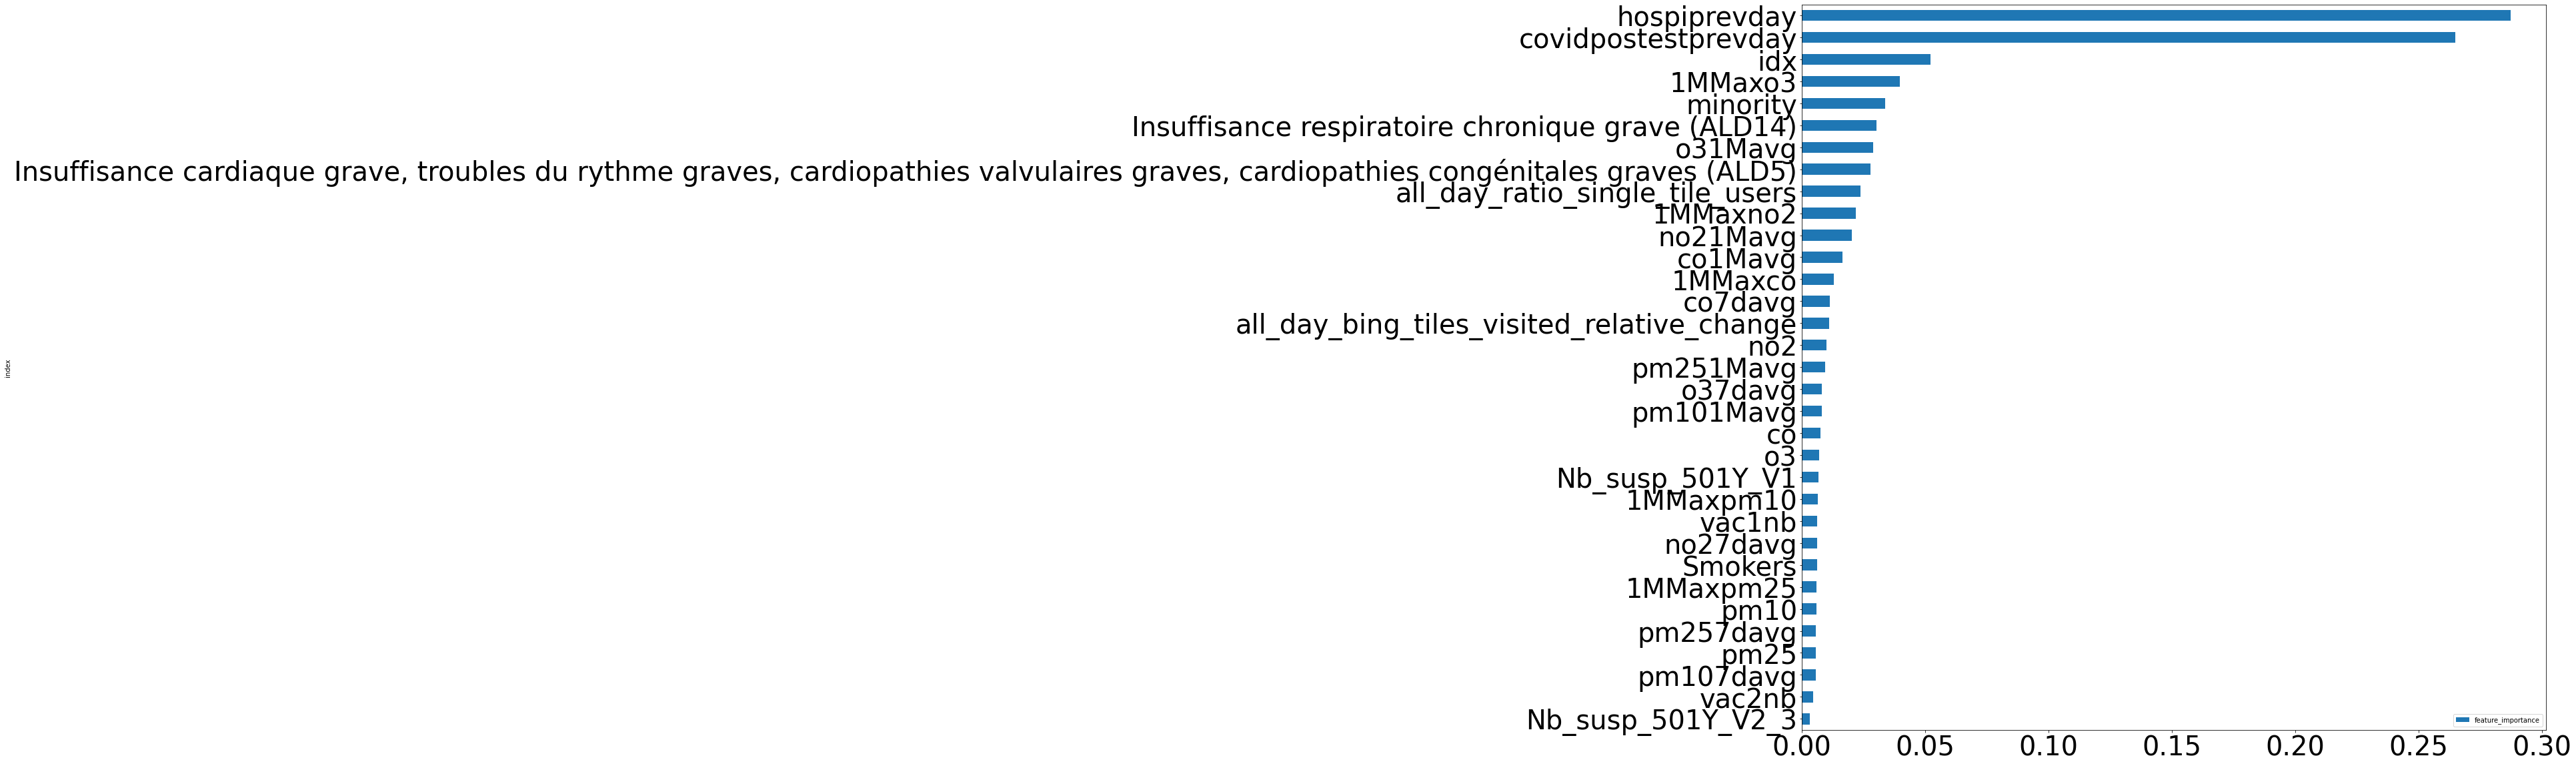

XGBoost- Extreme Gradient Regressor Feature importance report: [0.00893938 0.00413537 0.00474811 0.00670108 0.00682381 0.00698471
 0.00538269 0.00496142 0.00677234 0.01508631 0.00632461 0.22013411
 0.36659083 0.00993483 0.02994369 0.00977576 0.0207224  0.01383206
 0.01059771 0.00647083 0.0093684  0.02773965 0.02819513 0.00777685
 0.00439667 0.06307893 0.01022525 0.00983824 0.01357138 0.01036784
 0.01993983 0.01346142 0.01717838]
                                                index  feature_importance
1                                                pm25            0.004135
24                                          1MMaxpm10            0.004397
2                                                 no2            0.004748
7                                            no27davg            0.004961
6                                           pm257davg            0.005383
10                                          pm107davg            0.006325
19                                            Smo

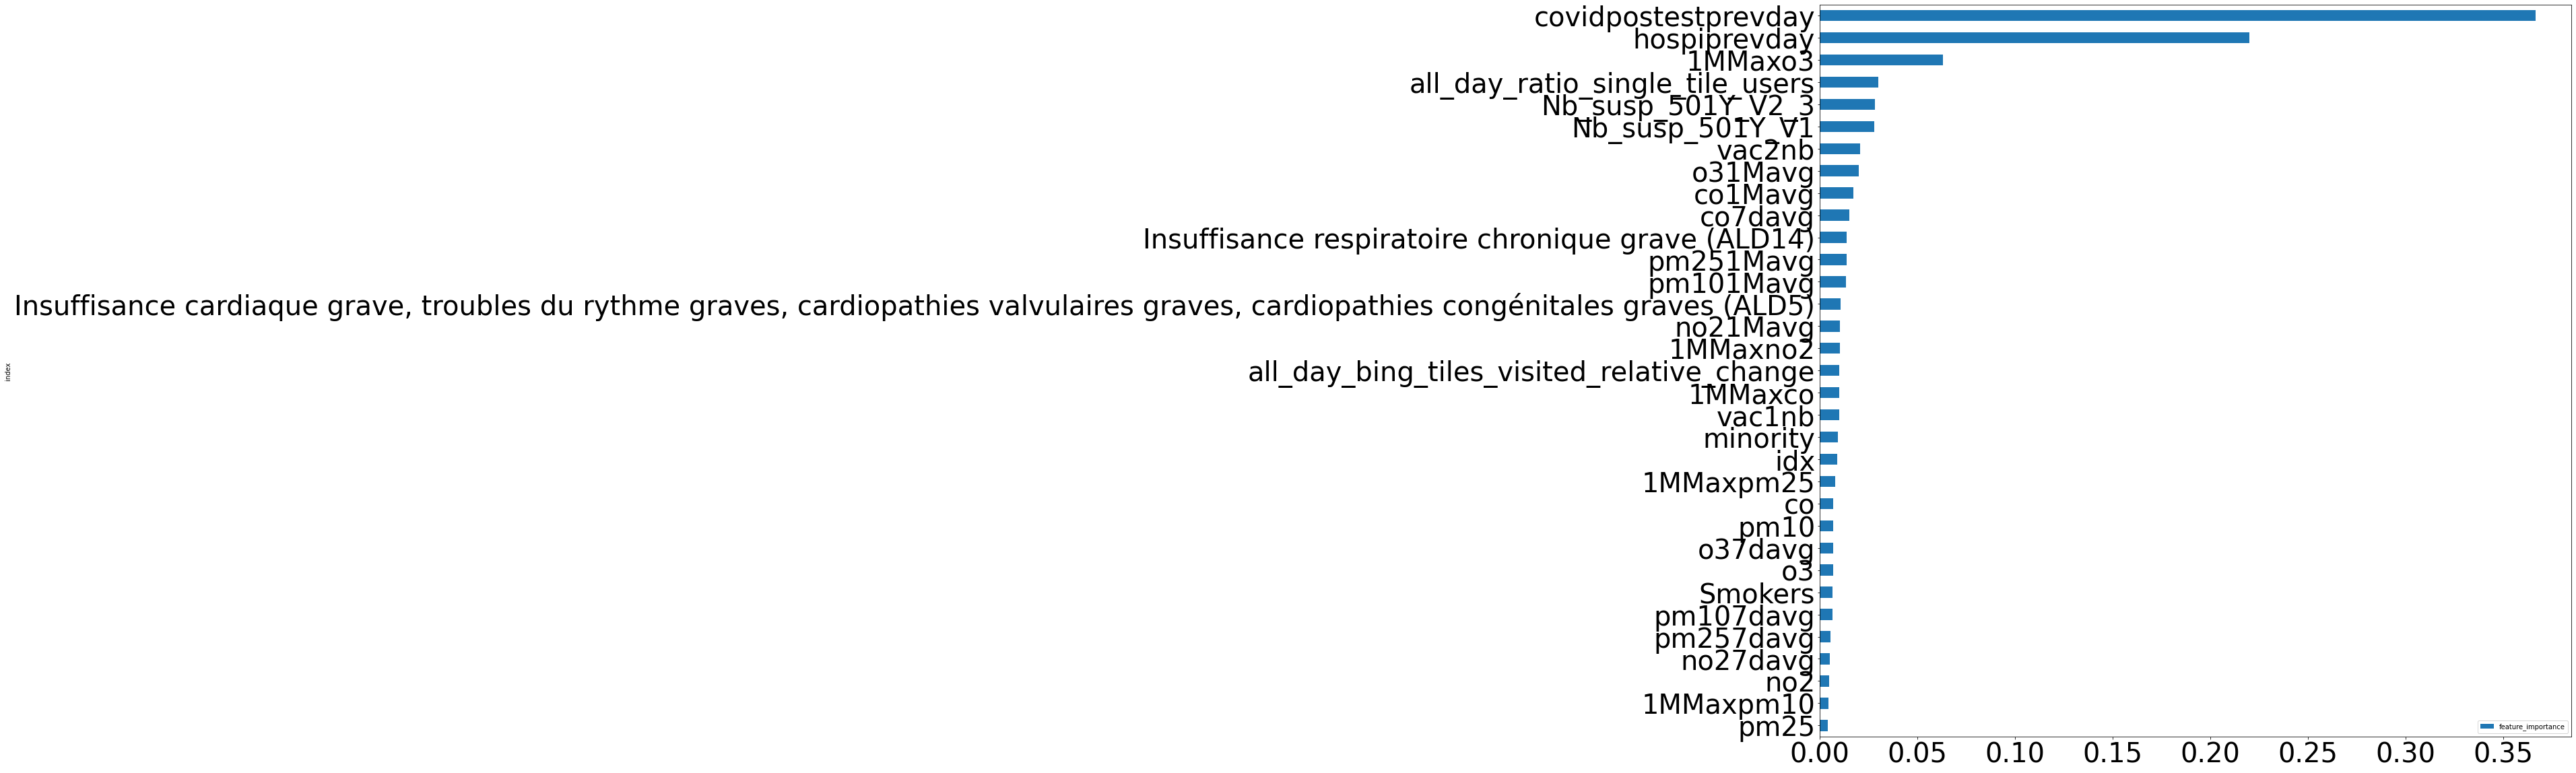

In [18]:
print("Scikit Learn - Extra Trees Regressor Feature importance report:", exported_pipeline.feature_importances_)
FIlist = exported_pipeline.feature_importances_.tolist()
FIlistdf = pd.DataFrame(FIlist)
FIlistdf = FIlistdf.T
FIlistdf.columns = features
FIlistdf = FIlistdf.T.reset_index()
FIlistdf.columns = ["index","feature_importance"]
FIlistdf.sort_values(by = ["feature_importance"], inplace = True, ascending =True)
print(FIlistdf)
print("\n")
fig = plt.figure(dpi = 150)
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
FIlistdf.plot.barh(x="index", y="feature_importance",figsize = (20,20))
plt.show() 


print("XGBoost- Extreme Gradient Regressor Feature importance report:", xgb_model.feature_importances_)
FIlist = xgb_model.feature_importances_.tolist()
FIlistdf = pd.DataFrame(FIlist)
FIlistdf = FIlistdf.T
FIlistdf.columns = features
FIlistdf = FIlistdf.T.reset_index()
FIlistdf.columns = ["index", "feature_importance"]
FIlistdf.sort_values(by = ["feature_importance"], inplace = True, ascending = True)
print(FIlistdf)
print("\n")
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40)
FIlistdf.plot.barh(x="index", y="feature_importance", figsize = (20,20))
plt.show() 


In [21]:
features3 = ["covidpostestprevday","hospiprevday","1MMaxo3","all_day_ratio_single_tile_users","Nb_susp_501Y_V1","Nb_susp_501Y_V2_3"]

In [26]:
#X3=df[features3]
X3 = df[features]
y= df['newhospi']
# Hold-out
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.33,random_state = 84)
print("\n")

In [27]:
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
scores = cross_validate(xgb_model, X_train, y_train, cv=5,
                        scoring=('neg_mean_squared_error',"neg_mean_absolute_error"),
                         return_train_score=True)
print(scores)

{'fit_time': array([6.97013521, 6.64780521, 6.50386405, 6.48796678, 6.92284513]), 'score_time': array([0.02923965, 0.02904081, 0.03017831, 0.03145123, 0.03280115]), 'test_neg_mean_squared_error': array([-53.18885982, -44.45821882, -52.93648881, -44.46396254,
       -48.4583109 ]), 'train_neg_mean_squared_error': array([-12.42806129, -12.26999031, -11.12328255, -12.22568885,
       -11.54658595]), 'test_neg_mean_absolute_error': array([-3.89512007, -3.70465642, -3.86400731, -3.70879258, -3.75372462]), 'train_neg_mean_absolute_error': array([-2.24365023, -2.23162264, -2.15510248, -2.23615336, -2.18895001])}


In [35]:
print(scores["test_neg_mean_squared_error"].mean())
print(scores["test_neg_mean_absolute_error"].mean())

-48.701168179472056
-3.785260201166173


In [36]:
exported_pipeline = ExtraTreesRegressor(bootstrap=False, \
            max_features=0.7000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)


In [37]:
scores = cross_validate(exported_pipeline, X_train, y_train, cv=5,
                        scoring=('neg_mean_squared_error',"neg_mean_absolute_error"),
                         return_train_score=True)
print(scores)

{'fit_time': array([8.40282106, 8.30150461, 8.36906934, 8.17666316, 7.89120126]), 'score_time': array([0.14989972, 0.12230754, 0.13081121, 0.13059235, 0.14415622]), 'test_neg_mean_squared_error': array([-50.11526568, -40.35436683, -48.60215359, -43.44010136,
       -46.4942127 ]), 'train_neg_mean_squared_error': array([-1.02406723, -1.12563796, -1.02816679, -1.08185641, -1.04410638]), 'test_neg_mean_absolute_error': array([-3.79630128, -3.60139297, -3.72870901, -3.67583089, -3.69930821]), 'train_neg_mean_absolute_error': array([-0.48709516, -0.48949322, -0.47957439, -0.47876007, -0.47700275])}


In [38]:
print(scores["test_neg_mean_squared_error"].mean())
print(scores["test_neg_mean_absolute_error"].mean())

-45.8012200311843
-3.700308469508216


In [32]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:




#Save model to .joblib file
# save the model to disk
filename = '../model/model.joblib'
joblib.dump(ensemble, filename)
 
# # some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)



print("\n")
print("TPOTRegressor")
tpot = TPOTRegressor(generations=50, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train2, y_train2)
print(tpot.score(X_test2, y_test2))
tpot.export('tpot_covid_pipeline.py')

print("\n")


In [ ]:
print("Neural Network")
X_trainNN = X_train2.values.reshape(X_train2.shape[0], X_train2.shape[1], 1)
y_trainNN = y_train2.values
X_testNN = X_test2.values.reshape(X_test2.shape[0],X_test2.shape[1],1)
y_testNN = y_test2.values
NNmodel = Sequential()
#NNmodel.add(layers.Dense(215, input_shape=(X_trainNN.shape[0], X_trainNN.shape[1])))
NNmodel.add(layers.LSTM(units=22, activation='tanh',return_sequences=True, input_shape=X_trainNN.shape[1:]))
NNmodel.add(layers.LSTM(units=10, activation='tanh', return_sequences=False))
NNmodel.add(layers.Dense(1, activation="linear"))

# The compilation
NNmodel.compile(loss='mse', 
              optimizer='rmsprop')

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

# The fit
NNmodel.fit(X_trainNN, y_trainNN,
         batch_size=16, validation_split = 0.3,
         epochs=100, verbose=1,callbacks=[es])

# The prediction
print("MSE:")
print(NNmodel.evaluate(X_testNN, y_testNN, verbose=0))

#print('validation loss (MSE):', val_loss, '\n validation MAE:', val_mae)
#print("Average error on new number of hospitalizations per day:", round(val_mae ** 0.5,0))